In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
import tensorflow as tf
tf.config.set_soft_device_placement(True)
tf.debugging.set_log_device_placement(True)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10933410552466807651
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11338085172
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6678561222730579523
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:08:00.0, compute capability: 3.7"
]


In [2]:

from glob import glob

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.table import Table

import os
import platform

mpl.rc('font', size=14)

In [3]:
import pickle 

with open('host_flux.data', 'rb') as filehandle:
    host_flux = pickle.load(filehandle)

In [4]:
with open('snia_flux.data', 'rb') as filehandle:
    # read the data as binary data stream
    snia_flux = pickle.load(filehandle)

In [5]:
with open('snib_flux.data', 'rb') as filehandle:
    # read the data as binary data stream
    snib_flux = pickle.load(filehandle)

In [6]:
with open('snibc_flux.data', 'rb') as filehandle:
    # read the data as binary data stream
    snibc_flux = pickle.load(filehandle)

In [7]:
with open('snic_flux.data', 'rb') as filehandle:
    # read the data as binary data stream
    snic_flux = pickle.load(filehandle)

In [8]:
with open('sniilp_flux .data', 'rb') as filehandle:
    # read the data as binary data stream
    sniilp_flux = pickle.load(filehandle)

In [9]:
with open('sniin_flux.data', 'rb') as filehandle:
    # read the data as binary data stream
    sniin_flux = pickle.load(filehandle)

In [10]:
with open('sniip_flux.data', 'rb') as filehandle:
    # read the data as binary data stream
    sniip_flux = pickle.load(filehandle)

In [11]:
nhost, nbins  = host_flux.shape
nsnia, nbins  = snia_flux.shape
nsnib, nbins  = snib_flux.shape
nsnibc, nbins = snibc_flux.shape
nsnic, nbins  = snic_flux.shape
nsniin, nbins = sniin_flux.shape
nsniilp, nbins = sniilp_flux.shape
nsniip, nbins = sniip_flux.shape
nhost, nsnia, nsnib, nsnibc, nsnic, nsniin, nsniilp, nsniip, nbins

(9969, 9964, 9958, 9971, 8269, 9949, 9948, 9962, 150)

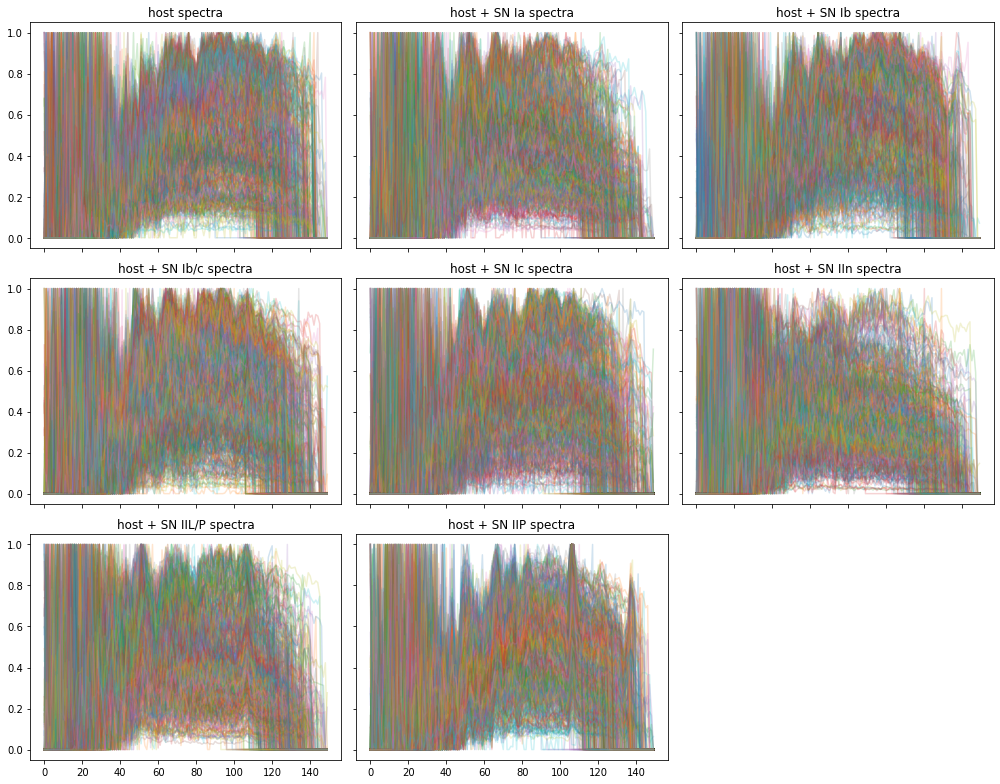

In [20]:
# PLOT
fig, axes = plt.subplots(3,3, figsize=(14,11), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(0,500):
    
    ax = axes[0]
    ax.plot(host_flux[i], alpha=0.2)

    ax = axes[1]
    ax.plot(snia_flux[i], alpha=0.2)
    
    ax = axes[2]
    ax.plot(snib_flux[i], alpha=0.2)
    
    ax = axes[3]
    ax.plot(snibc_flux[i], alpha=0.2)
    
    ax = axes[4]
    ax.plot(snic_flux[i], alpha=0.2)
    
    ax = axes[5]
    ax.plot(sniin_flux[i], alpha=0.2)

    ax = axes[6]
    ax.plot(sniilp_flux[i], alpha=0.2)
    
    ax = axes[7]
    ax.plot(sniip_flux[i], alpha=0.2)
    
axes[0].set_title('host spectra')
axes[1].set_title('host + SN Ia spectra')
axes[2].set_title('host + SN Ib spectra')
axes[3].set_title('host + SN Ib/c spectra')
axes[4].set_title('host + SN Ic spectra')
axes[5].set_title('host + SN IIn spectra')
axes[6].set_title('host + SN IIL/P spectra')
axes[7].set_title('host + SN IIP spectra')

axes[8].axis('off')

fig.tight_layout()


x = np.concatenate([host_flux, 
                    snia_flux,
                    snib_flux,
                    snibc_flux,
                    snic_flux,
                    sniin_flux,
                    sniilp_flux,
                    sniip_flux
                   ]).reshape(-1, nbins, 1)

labels = ['Host',
          'SN Ia',
          'SN Ib',
          'SN Ib/c',
          'SN Ic',
          'SN IIn',
          'SN IIL/P',
          'SN IIP']
ntypes = len(labels)

# Convert y-label array to appropriate categorical array
from tensorflow.keras.utils import to_categorical

y = to_categorical(
        np.concatenate([np.full(nhost, 0), 
                        np.full(nsnia, 1),
                        np.full(nsnib, 2),
                        np.full(nsnibc, 3),
                        np.full(nsnic, 4),
                        np.full(nsniin, 5),
                        np.full(nsniilp, 6),
                        np.full(nsniip, 7)
                       ]))

In [21]:
import tensorflow as tf
from tensorflow.keras import utils, regularizers, callbacks, backend
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding1D, BatchNormalization, Flatten, Reshape, Conv1D, MaxPooling1D, Dropout, Add, LSTM, Embedding
from tensorflow.keras.initializers import glorot_normal, glorot_uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import LSTM

In [14]:
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

# Grid Search

from keras import backend as K
def generate_model(input_shape=(nbins, 1),ncat=y.shape[1], learning_rate=0.0005, reg=0.0032, dropout=0.7436, seed=1):
    """ 
    Args:
    input_shape -- shape of the input spectra
    regularization_strength -- regularization factor
    dropout -- dropout rate
    seed -- seed of initializer
    Returns:
    model -- a Model() instance in Keras
    """

    X_input = Input(input_shape, name='Input_Spec')

    # First convolutional layer.
    with backend.name_scope('Conv_1'):
        X = Conv1D(filters=8, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X_input)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(pool_size= 2)(X)

    # Second convolutional layer.
    with backend.name_scope('Conv_2'):
        X = Conv1D(filters=16, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Third convolutional layer.
    with backend.name_scope('Conv_3'):
        X = Conv1D(filters=32, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Fourth convolutional layer.
    with backend.name_scope('Conv_4'):
        X = Conv1D(filters=64, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)

    # Flatten to fully connected dense layer.
    with backend.name_scope('Dense_Layer'):
        X = Flatten()(X)
        X = Dense(256, kernel_regularizer=regularizers.l2(reg),
                  activation='relu')(X)
        X = Dropout(rate=dropout, seed=seed)(X)
    
    # Output layer with sigmoid activation.
    with backend.name_scope('Output_Layer'):
        X = Dense(ncat, kernel_regularizer=regularizers.l2(reg),
              activation='sigmoid',name='Output_Classes')(X)

    model = Model(inputs=X_input, outputs=X, name='SNnet')
    
    # Set up optimizer, loss function, and optimization metrics.
    model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

Using TensorFlow backend.


In [15]:
model = generate_model()
model.summary()

W0723 16:42:20.805712 47824211592064 nn_ops.py:4220] Large dropout rate: 0.7436 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Model: "SNnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Spec (InputLayer)      [(None, 150, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 150, 8)            48        
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 8)            32        
_________________________________________________________________
activation (Activation)      (None, 150, 8)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 75, 8)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 75, 16)            656       
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 16)            64    

In [22]:
import hyperopt, hyperas

from keras.wrappers.scikit_learn import KerasClassifier
model = KerasClassifier(build_fn =generate_model,epochs = 25, batch_size = 64)
lrlist = np.logspace(-5,-1,7)
lrlist = lrlist.tolist()
ins = ((150,1),)
lr= lrlist
reg=(0.0032,)
dr = [0.1,0.2,0.4,0.6,0.8]
seed = (1,)

In [23]:
# Prepare the Grid
param_grid = dict(input_shape=ins, learning_rate=lr, reg=reg, dropout=dr, seed=seed)
type(param_grid)

dict

In [24]:
# Split data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [25]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=None, cv=3, verbose=2)

In [26]:
grid_result = grid.fit(x_train, y_train) # 30 epochs

Fitting 3 folds for each of 35 candidates, totalling 105 fits
[CV] dropout=0.1, input_shape=(150, 1), learning_rate=1e-05, reg=0.0032, seed=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
W0723 16:44:56.691023 47824211592064 deprecation.py:323] From /software/tensorflow/2.0.0b/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 38994 samples
Epoch 1/25
38994/38994 [==============================] - 7s 182us/sample - loss: 3.4605 - acc: 0.1682
Epoch 2/25
38994/38994 [==============================] - 5s 135us/sample - loss: 3.3170 - acc: 0.2308
Epoch 3/25
38994/38994 [==============================] - 5s 134us/sample - loss: 3.2017 - acc: 0.2670
Epoch 4/25
38994/38994 [==============================] - 5s 134us/sample - loss: 3.0985 - acc: 0.2970
Epoch 5/25
38994/38994 [==============================] - 5s 134us/sample - loss: 3.0014 - acc: 0.3257
Epoch 6/25
38994/38994 [==============================] - 5s 134us/sample - loss: 2.9167 - acc: 0.3487
Epoch 7/25
38994/38994 [==============================] - 5s 134us/sample - loss: 2.8392 - acc: 0.3708
Epoch 8/25
38994/38994 [==============================] - 5s 136us/sample - loss: 2.7691 - acc: 0.3905
Epoch 9/25
38994/38994 [==============================] - 5s 134us/sample - loss: 2.7044 - acc: 0.4087
Epoch 10/25
38994/38994 [=========================

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.3min remaining:    0.0s


Train on 38995 samples
Epoch 1/25
38995/38995 [==============================] - 6s 153us/sample - loss: 3.4810 - acc: 0.1555
Epoch 2/25
38995/38995 [==============================] - 5s 135us/sample - loss: 3.3318 - acc: 0.2180
Epoch 3/25
38995/38995 [==============================] - 5s 135us/sample - loss: 3.2029 - acc: 0.2650
Epoch 4/25
38995/38995 [==============================] - 5s 135us/sample - loss: 3.0879 - acc: 0.3059
Epoch 5/25
38995/38995 [==============================] - 5s 135us/sample - loss: 2.9898 - acc: 0.3360
Epoch 6/25
38995/38995 [==============================] - 5s 136us/sample - loss: 2.9029 - acc: 0.3620
Epoch 7/25
38995/38995 [==============================] - 5s 135us/sample - loss: 2.8227 - acc: 0.3877
Epoch 8/25
38995/38995 [==============================] - 5s 136us/sample - loss: 2.7523 - acc: 0.4060
Epoch 9/25
38995/38995 [==============================] - 5s 135us/sample - loss: 2.6906 - acc: 0.4211
Epoch 10/25
38995/38995 [=========================

38994/38994 [==============================] - 5s 139us/sample - loss: 1.3594 - acc: 0.6787
Epoch 25/25
19498/19498 [==============================] - 1s 52us/sample - loss: 1.3982 - acc: 0.6525
[CV]  dropout=0.1, input_shape=(150, 1), learning_rate=4.641588833612782e-05, reg=0.0032, seed=1, total= 2.3min
[CV] dropout=0.1, input_shape=(150, 1), learning_rate=4.641588833612782e-05, reg=0.0032, seed=1 
Train on 38995 samples
Epoch 1/25
38995/38995 [==============================] - 6s 152us/sample - loss: 3.2464 - acc: 0.2287
Epoch 2/25
38995/38995 [==============================] - 5s 139us/sample - loss: 2.7625 - acc: 0.3839
Epoch 3/25
38995/38995 [==============================] - 5s 138us/sample - loss: 2.4715 - acc: 0.4588
Epoch 4/25
38995/38995 [==============================] - 5s 138us/sample - loss: 2.2984 - acc: 0.4990
Epoch 5/25
38995/38995 [==============================] - 5s 139us/sample - loss: 2.1638 - acc: 0.5284
Epoch 6/25
38995/38995 [==============================] - 

Epoch 13/25
38994/38994 [==============================] - 5s 140us/sample - loss: 1.0349 - acc: 0.7021
Epoch 14/25
38994/38994 [==============================] - 5s 139us/sample - loss: 1.0283 - acc: 0.7065
Epoch 15/25
38994/38994 [==============================] - 6s 142us/sample - loss: 1.0302 - acc: 0.7040
Epoch 16/25
38994/38994 [==============================] - 5s 141us/sample - loss: 1.0245 - acc: 0.7084
Epoch 17/25
38994/38994 [==============================] - 5s 140us/sample - loss: 1.0173 - acc: 0.7104
Epoch 18/25
38994/38994 [==============================] - 5s 139us/sample - loss: 1.0166 - acc: 0.7086
Epoch 19/25
38994/38994 [==============================] - 5s 139us/sample - loss: 1.0144 - acc: 0.7096
Epoch 20/25
38994/38994 [==============================] - 5s 140us/sample - loss: 1.0112 - acc: 0.7088
Epoch 21/25
38994/38994 [==============================] - 5s 140us/sample - loss: 1.0032 - acc: 0.7117
Epoch 22/25
38994/38994 [==============================] - 5s 14

38994/38994 [==============================] - 6s 141us/sample - loss: 1.6873 - acc: 0.4228
Epoch 3/25
38994/38994 [==============================] - 6s 142us/sample - loss: 1.6349 - acc: 0.4427
Epoch 4/25
38994/38994 [==============================] - 6s 142us/sample - loss: 1.5995 - acc: 0.4555
Epoch 5/25
38994/38994 [==============================] - 6s 142us/sample - loss: 1.6040 - acc: 0.4547
Epoch 6/25
38994/38994 [==============================] - 6s 144us/sample - loss: 1.5917 - acc: 0.4582
Epoch 7/25
38994/38994 [==============================] - 6s 143us/sample - loss: 1.5858 - acc: 0.4600
Epoch 8/25
38994/38994 [==============================] - 6s 142us/sample - loss: 1.5804 - acc: 0.4647
Epoch 9/25
38994/38994 [==============================] - 6s 142us/sample - loss: 1.5835 - acc: 0.4600
Epoch 10/25
38994/38994 [==============================] - 6s 143us/sample - loss: 1.5773 - acc: 0.4626
Epoch 11/25
38994/38994 [==============================] - 6s 143us/sample - loss: 

Epoch 25/25
19497/19497 [==============================] - 1s 71us/sample - loss: 1.7259 - acc: 0.3717
[CV]  dropout=0.1, input_shape=(150, 1), learning_rate=0.021544346900318822, reg=0.0032, seed=1, total= 2.4min
[CV] dropout=0.1, input_shape=(150, 1), learning_rate=0.1, reg=0.0032, seed=1 
Train on 38994 samples
Epoch 1/25
38994/38994 [==============================] - 6s 163us/sample - loss: 2.5670 - acc: 0.1234
Epoch 2/25
38994/38994 [==============================] - 6s 143us/sample - loss: 2.0776 - acc: 0.1257
Epoch 3/25
38994/38994 [==============================] - 6s 144us/sample - loss: 2.0780 - acc: 0.1288
Epoch 4/25
38994/38994 [==============================] - 6s 144us/sample - loss: 2.0779 - acc: 0.1303
Epoch 5/25
38994/38994 [==============================] - 6s 143us/sample - loss: 2.0782 - acc: 0.1316
Epoch 6/25
38994/38994 [==============================] - 6s 144us/sample - loss: 2.0784 - acc: 0.1316
Epoch 7/25
38994/38994 [==============================] - 6s 144us

38995/38995 [==============================] - 6s 145us/sample - loss: 2.4680 - acc: 0.4627
Epoch 16/25
38995/38995 [==============================] - 6s 144us/sample - loss: 2.4289 - acc: 0.4745
Epoch 17/25
38995/38995 [==============================] - 6s 144us/sample - loss: 2.3955 - acc: 0.4814
Epoch 18/25
38995/38995 [==============================] - 6s 145us/sample - loss: 2.3667 - acc: 0.4868
Epoch 19/25
38995/38995 [==============================] - 6s 144us/sample - loss: 2.3343 - acc: 0.4939
Epoch 20/25
38995/38995 [==============================] - 6s 145us/sample - loss: 2.3059 - acc: 0.5037
Epoch 21/25
38995/38995 [==============================] - 6s 144us/sample - loss: 2.2826 - acc: 0.5102
Epoch 22/25
38995/38995 [==============================] - 6s 144us/sample - loss: 2.2495 - acc: 0.5160
Epoch 23/25
38995/38995 [==============================] - 6s 144us/sample - loss: 2.2299 - acc: 0.5202
Epoch 24/25
38995/38995 [==============================] - 6s 144us/sample -

Epoch 10/25
38995/38995 [==============================] - 6s 145us/sample - loss: 1.8160 - acc: 0.5941
Epoch 11/25
38995/38995 [==============================] - 6s 145us/sample - loss: 1.7598 - acc: 0.6047
Epoch 12/25
38995/38995 [==============================] - 6s 145us/sample - loss: 1.7149 - acc: 0.6121
Epoch 13/25
38995/38995 [==============================] - 6s 147us/sample - loss: 1.6715 - acc: 0.6204
Epoch 14/25
38995/38995 [==============================] - 6s 147us/sample - loss: 1.6320 - acc: 0.6272
Epoch 15/25
38995/38995 [==============================] - 6s 146us/sample - loss: 1.5965 - acc: 0.6302
Epoch 16/25
38995/38995 [==============================] - 6s 145us/sample - loss: 1.5626 - acc: 0.6363
Epoch 17/25
38995/38995 [==============================] - 6s 145us/sample - loss: 1.5323 - acc: 0.6422
Epoch 18/25
38995/38995 [==============================] - 6s 145us/sample - loss: 1.5024 - acc: 0.6481
Epoch 19/25
38995/38995 [==============================] - 6s 14

Train on 38995 samples
Epoch 1/25
38995/38995 [==============================] - 7s 175us/sample - loss: 1.9188 - acc: 0.4509
Epoch 2/25
38995/38995 [==============================] - 6s 148us/sample - loss: 1.3135 - acc: 0.6205
Epoch 3/25
38995/38995 [==============================] - 6s 148us/sample - loss: 1.2145 - acc: 0.6454
Epoch 4/25
38995/38995 [==============================] - 6s 148us/sample - loss: 1.1662 - acc: 0.6588
Epoch 5/25
38995/38995 [==============================] - 6s 148us/sample - loss: 1.1337 - acc: 0.6712
Epoch 6/25
38995/38995 [==============================] - 6s 148us/sample - loss: 1.1185 - acc: 0.6773
Epoch 7/25
38995/38995 [==============================] - 6s 148us/sample - loss: 1.1029 - acc: 0.6790
Epoch 8/25
38995/38995 [==============================] - 6s 148us/sample - loss: 1.0904 - acc: 0.6849
Epoch 9/25
38995/38995 [==============================] - 6s 148us/sample - loss: 1.0848 - acc: 0.6869
Epoch 10/25
38995/38995 [=========================

38995/38995 [==============================] - 6s 149us/sample - loss: 1.5657 - acc: 0.4858
Epoch 18/25
38995/38995 [==============================] - 6s 149us/sample - loss: 1.5621 - acc: 0.4857
Epoch 19/25
38995/38995 [==============================] - 6s 150us/sample - loss: 1.5704 - acc: 0.4851
Epoch 20/25
38995/38995 [==============================] - 6s 150us/sample - loss: 1.5520 - acc: 0.4893
Epoch 21/25
38995/38995 [==============================] - 6s 149us/sample - loss: 1.5624 - acc: 0.4830
Epoch 22/25
38995/38995 [==============================] - 6s 149us/sample - loss: 1.5641 - acc: 0.4841
Epoch 23/25
38995/38995 [==============================] - 6s 150us/sample - loss: 1.5703 - acc: 0.4844
Epoch 24/25
38995/38995 [==============================] - 6s 153us/sample - loss: 1.5637 - acc: 0.4840
Epoch 25/25
19497/19497 [==============================] - 2s 98us/sample - loss: 1.6288 - acc: 0.4450
[CV]  dropout=0.2, input_shape=(150, 1), learning_rate=0.021544346900318822, 

38995/38995 [==============================] - 6s 151us/sample - loss: 2.9334 - acc: 0.3043
Epoch 8/25
38995/38995 [==============================] - 6s 151us/sample - loss: 2.8688 - acc: 0.3227
Epoch 9/25
38995/38995 [==============================] - 6s 150us/sample - loss: 2.8084 - acc: 0.3343
Epoch 10/25
38995/38995 [==============================] - 6s 151us/sample - loss: 2.7474 - acc: 0.3533
Epoch 11/25
38995/38995 [==============================] - 6s 151us/sample - loss: 2.6917 - acc: 0.3697
Epoch 12/25
38995/38995 [==============================] - 6s 150us/sample - loss: 2.6361 - acc: 0.3835
Epoch 13/25
38995/38995 [==============================] - 6s 150us/sample - loss: 2.5859 - acc: 0.3981
Epoch 14/25
38995/38995 [==============================] - 6s 152us/sample - loss: 2.5443 - acc: 0.4081
Epoch 15/25
38995/38995 [==============================] - 6s 151us/sample - loss: 2.4994 - acc: 0.4181
Epoch 16/25
38995/38995 [==============================] - 6s 150us/sample - l

38994/38994 [==============================] - 6s 153us/sample - loss: 0.9931 - acc: 0.7252
Epoch 25/25
19498/19498 [==============================] - 2s 113us/sample - loss: 1.0855 - acc: 0.6899
[CV]  dropout=0.4, input_shape=(150, 1), learning_rate=0.00021544346900318823, reg=0.0032, seed=1, total= 2.8min
[CV] dropout=0.4, input_shape=(150, 1), learning_rate=0.00021544346900318823, reg=0.0032, seed=1 
Train on 38995 samples
Epoch 1/25
38995/38995 [==============================] - 7s 189us/sample - loss: 2.8067 - acc: 0.3264
Epoch 2/25
38995/38995 [==============================] - 6s 156us/sample - loss: 2.0447 - acc: 0.5119
Epoch 3/25
38995/38995 [==============================] - 6s 153us/sample - loss: 1.7421 - acc: 0.5727
Epoch 4/25
38995/38995 [==============================] - 6s 153us/sample - loss: 1.5713 - acc: 0.6039
Epoch 5/25
38995/38995 [==============================] - 6s 153us/sample - loss: 1.4513 - acc: 0.6272
Epoch 6/25
38995/38995 [==============================]

38994/38994 [==============================] - 6s 157us/sample - loss: 1.3035 - acc: 0.6214
Epoch 14/25
38994/38994 [==============================] - 6s 156us/sample - loss: 1.3047 - acc: 0.6202
Epoch 15/25
38994/38994 [==============================] - 6s 156us/sample - loss: 1.3085 - acc: 0.6182
Epoch 16/25
38994/38994 [==============================] - 6s 156us/sample - loss: 1.3012 - acc: 0.6229
Epoch 17/25
38994/38994 [==============================] - 6s 156us/sample - loss: 1.2982 - acc: 0.6198
Epoch 18/25
38994/38994 [==============================] - 6s 156us/sample - loss: 1.3017 - acc: 0.6198
Epoch 19/25
38994/38994 [==============================] - 6s 156us/sample - loss: 1.2953 - acc: 0.6217
Epoch 20/25
38994/38994 [==============================] - 6s 158us/sample - loss: 1.2887 - acc: 0.6208
Epoch 21/25
38994/38994 [==============================] - 6s 156us/sample - loss: 1.2982 - acc: 0.6161
Epoch 22/25
38994/38994 [==============================] - 6s 159us/sample -

Epoch 2/25
38994/38994 [==============================] - 6s 158us/sample - loss: 2.0787 - acc: 0.1269
Epoch 3/25
38994/38994 [==============================] - 6s 160us/sample - loss: 2.0779 - acc: 0.1297
Epoch 4/25
38994/38994 [==============================] - 6s 158us/sample - loss: 2.0780 - acc: 0.1316
Epoch 5/25
38994/38994 [==============================] - 6s 158us/sample - loss: 2.0780 - acc: 0.1316
Epoch 6/25
38994/38994 [==============================] - 6s 158us/sample - loss: 2.0781 - acc: 0.1316
Epoch 7/25
38994/38994 [==============================] - 6s 157us/sample - loss: 2.0780 - acc: 0.1316
Epoch 8/25
38994/38994 [==============================] - 6s 158us/sample - loss: 2.0782 - acc: 0.1316
Epoch 9/25
38994/38994 [==============================] - 6s 161us/sample - loss: 2.0782 - acc: 0.1316
Epoch 10/25
38994/38994 [==============================] - 6s 158us/sample - loss: 2.0781 - acc: 0.1316
Epoch 11/25
38994/38994 [==============================] - 6s 157us/samp

W0723 19:28:29.517103 47824211592064 nn_ops.py:4220] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Train on 38994 samples
Epoch 1/25
38994/38994 [==============================] - 8s 205us/sample - loss: 3.5967 - acc: 0.1344
Epoch 2/25
38994/38994 [==============================] - 6s 159us/sample - loss: 3.4458 - acc: 0.1535
Epoch 3/25
38994/38994 [==============================] - 6s 159us/sample - loss: 3.3647 - acc: 0.1686
Epoch 4/25
38994/38994 [==============================] - 6s 159us/sample - loss: 3.2889 - acc: 0.1869
Epoch 5/25
38994/38994 [==============================] - 6s 159us/sample - loss: 3.2101 - acc: 0.2063
Epoch 6/25
38994/38994 [==============================] - 6s 159us/sample - loss: 3.1295 - acc: 0.2274
Epoch 7/25
38994/38994 [==============================] - 6s 159us/sample - loss: 3.0615 - acc: 0.2402
Epoch 8/25
38994/38994 [==============================] - 6s 159us/sample - loss: 3.0011 - acc: 0.2579
Epoch 9/25
38994/38994 [==============================] - 6s 159us/sample - loss: 2.9479 - acc: 0.2675
Epoch 10/25
38994/38994 [=========================

W0723 19:31:27.729228 47824211592064 nn_ops.py:4220] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Train on 38995 samples
Epoch 1/25
38995/38995 [==============================] - 8s 202us/sample - loss: 3.5799 - acc: 0.1312
Epoch 2/25
38995/38995 [==============================] - 6s 159us/sample - loss: 3.4391 - acc: 0.1527
Epoch 3/25
38995/38995 [==============================] - 6s 159us/sample - loss: 3.3612 - acc: 0.1616
Epoch 4/25
38995/38995 [==============================] - 6s 159us/sample - loss: 3.2894 - acc: 0.1792
Epoch 5/25
38995/38995 [==============================] - 6s 159us/sample - loss: 3.2032 - acc: 0.2035
Epoch 6/25
38995/38995 [==============================] - 6s 158us/sample - loss: 3.1204 - acc: 0.2284
Epoch 7/25
38995/38995 [==============================] - 6s 159us/sample - loss: 3.0521 - acc: 0.2442
Epoch 8/25
38995/38995 [==============================] - 6s 158us/sample - loss: 2.9876 - acc: 0.2579
Epoch 9/25
38995/38995 [==============================] - 6s 158us/sample - loss: 2.9335 - acc: 0.2709
Epoch 10/25
38995/38995 [=========================

W0723 19:34:24.100660 47824211592064 nn_ops.py:4220] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Train on 38995 samples
Epoch 1/25
38995/38995 [==============================] - 8s 203us/sample - loss: 3.5454 - acc: 0.1394
Epoch 2/25
38995/38995 [==============================] - 6s 162us/sample - loss: 3.4254 - acc: 0.1579
Epoch 3/25
38995/38995 [==============================] - 6s 161us/sample - loss: 3.3413 - acc: 0.1839
Epoch 4/25
38995/38995 [==============================] - 6s 159us/sample - loss: 3.2591 - acc: 0.2015
Epoch 5/25
38995/38995 [==============================] - 6s 159us/sample - loss: 3.1817 - acc: 0.2189
Epoch 6/25
38995/38995 [==============================] - 6s 160us/sample - loss: 3.1125 - acc: 0.2361
Epoch 7/25
38995/38995 [==============================] - 6s 160us/sample - loss: 3.0445 - acc: 0.2493
Epoch 8/25
38995/38995 [==============================] - 6s 159us/sample - loss: 2.9866 - acc: 0.2655
Epoch 9/25
38995/38995 [==============================] - 6s 159us/sample - loss: 2.9310 - acc: 0.2774
Epoch 10/25
38995/38995 [=========================

W0723 19:37:21.151556 47824211592064 nn_ops.py:4220] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Train on 38994 samples
Epoch 1/25
38994/38994 [==============================] - 8s 205us/sample - loss: 3.4022 - acc: 0.1573
Epoch 2/25
38994/38994 [==============================] - 6s 163us/sample - loss: 3.0534 - acc: 0.2419
Epoch 3/25
38994/38994 [==============================] - 6s 161us/sample - loss: 2.7839 - acc: 0.3034
Epoch 4/25
38994/38994 [==============================] - 6s 160us/sample - loss: 2.5751 - acc: 0.3634
Epoch 5/25
38994/38994 [==============================] - 6s 160us/sample - loss: 2.3919 - acc: 0.4158
Epoch 6/25
38994/38994 [==============================] - 6s 160us/sample - loss: 2.2519 - acc: 0.4501
Epoch 7/25
38994/38994 [==============================] - 6s 161us/sample - loss: 2.1405 - acc: 0.4786
Epoch 8/25
38994/38994 [==============================] - 6s 160us/sample - loss: 2.0486 - acc: 0.5028
Epoch 9/25
38994/38994 [==============================] - 6s 160us/sample - loss: 1.9722 - acc: 0.5213
Epoch 10/25
38994/38994 [=========================

38995/38995 [==============================] - 6s 163us/sample - loss: nan - acc: 0.1280
Epoch 19/25
38995/38995 [==============================] - 6s 163us/sample - loss: nan - acc: 0.1280
Epoch 20/25
38995/38995 [==============================] - 6s 163us/sample - loss: nan - acc: 0.1280
Epoch 21/25
38995/38995 [==============================] - 6s 163us/sample - loss: nan - acc: 0.1280
Epoch 22/25
38995/38995 [==============================] - 6s 166us/sample - loss: nan - acc: 0.1280
Epoch 23/25
38995/38995 [==============================] - 6s 163us/sample - loss: nan - acc: 0.1280
Epoch 24/25
38995/38995 [==============================] - 6s 164us/sample - loss: nan - acc: 0.1280
Epoch 25/25
19497/19497 [==============================] - 3s 147us/sample - loss: nan - acc: 0.1260
[CV]  dropout=0.6, input_shape=(150, 1), learning_rate=0.00021544346900318823, reg=0.0032, seed=1, total= 3.0min
[CV] dropout=0.6, input_shape=(150, 1), learning_rate=0.001, reg=0.0032, seed=1 
Train on 3

Epoch 8/25
38995/38995 [==============================] - 6s 163us/sample - loss: 1.4359 - acc: 0.5556
Epoch 9/25
38995/38995 [==============================] - 6s 163us/sample - loss: 1.4309 - acc: 0.5586
Epoch 10/25
38995/38995 [==============================] - 6s 165us/sample - loss: 1.4269 - acc: 0.5593
Epoch 11/25
38995/38995 [==============================] - 6s 164us/sample - loss: 1.4168 - acc: 0.5621
Epoch 12/25
38995/38995 [==============================] - 6s 163us/sample - loss: 1.4079 - acc: 0.5678
Epoch 13/25
38995/38995 [==============================] - 6s 163us/sample - loss: 1.4100 - acc: 0.5677
Epoch 14/25
38995/38995 [==============================] - 6s 164us/sample - loss: 1.4074 - acc: 0.5685
Epoch 15/25
38995/38995 [==============================] - 6s 164us/sample - loss: 1.4080 - acc: 0.5658
Epoch 16/25
38995/38995 [==============================] - 6s 163us/sample - loss: 1.4035 - acc: 0.5684
Epoch 17/25
38995/38995 [==============================] - 6s 163u

19497/19497 [==============================] - 3s 160us/sample - loss: 2.0780 - acc: 0.1301
[CV]  dropout=0.6, input_shape=(150, 1), learning_rate=0.1, reg=0.0032, seed=1, total= 3.1min
[CV] dropout=0.6, input_shape=(150, 1), learning_rate=0.1, reg=0.0032, seed=1 
Train on 38995 samples
Epoch 1/25
38995/38995 [==============================] - 8s 218us/sample - loss: 2.9794 - acc: 0.1248
Epoch 2/25
38995/38995 [==============================] - 6s 166us/sample - loss: 2.0802 - acc: 0.1275
Epoch 3/25
38995/38995 [==============================] - 6s 166us/sample - loss: 2.0784 - acc: 0.1282
Epoch 4/25
38995/38995 [==============================] - 6s 166us/sample - loss: 2.0784 - acc: 0.1284
Epoch 5/25
38995/38995 [==============================] - 7s 168us/sample - loss: 2.0785 - acc: 0.1296
Epoch 6/25
38995/38995 [==============================] - 7s 167us/sample - loss: 2.0787 - acc: 0.1296
Epoch 7/25
38995/38995 [==============================] - 6s 166us/sample - loss: 2.0786 - acc

38995/38995 [==============================] - 7s 170us/sample - loss: 1.8111 - acc: 0.5281
Epoch 16/25
38995/38995 [==============================] - 7s 168us/sample - loss: 1.7763 - acc: 0.5367
Epoch 17/25
38995/38995 [==============================] - 7s 168us/sample - loss: 1.7410 - acc: 0.5470
Epoch 18/25
38995/38995 [==============================] - 7s 168us/sample - loss: 1.7046 - acc: 0.5546
Epoch 19/25
38995/38995 [==============================] - 7s 169us/sample - loss: 1.6748 - acc: 0.5621
Epoch 20/25
38995/38995 [==============================] - 7s 168us/sample - loss: 1.6486 - acc: 0.5684
Epoch 21/25
38995/38995 [==============================] - 7s 168us/sample - loss: 1.6230 - acc: 0.5778
Epoch 22/25
38995/38995 [==============================] - 7s 170us/sample - loss: 1.6002 - acc: 0.5787
Epoch 23/25
38995/38995 [==============================] - 7s 169us/sample - loss: 1.5778 - acc: 0.5879
Epoch 24/25
38995/38995 [==============================] - 7s 171us/sample -

38995/38995 [==============================] - 7s 171us/sample - loss: 1.3548 - acc: 0.5984
Epoch 7/25
38995/38995 [==============================] - 7s 172us/sample - loss: 1.3336 - acc: 0.6085
Epoch 8/25
38995/38995 [==============================] - 7s 171us/sample - loss: 1.3243 - acc: 0.6111
Epoch 9/25
38995/38995 [==============================] - 7s 171us/sample - loss: 1.3080 - acc: 0.6192
Epoch 10/25
38995/38995 [==============================] - 7s 171us/sample - loss: 1.2979 - acc: 0.6211
Epoch 11/25
38995/38995 [==============================] - 7s 171us/sample - loss: 1.2910 - acc: 0.6222
Epoch 12/25
38995/38995 [==============================] - 7s 170us/sample - loss: 1.2801 - acc: 0.6304
Epoch 13/25
38995/38995 [==============================] - 7s 170us/sample - loss: 1.2750 - acc: 0.6270
Epoch 14/25
38995/38995 [==============================] - 7s 170us/sample - loss: 1.2666 - acc: 0.6348
Epoch 15/25
38995/38995 [==============================] - 7s 171us/sample - lo

Epoch 24/25
38994/38994 [==============================] - 7s 172us/sample - loss: 2.0103 - acc: 0.1967
Epoch 25/25
19498/19498 [==============================] - 4s 182us/sample - loss: 2.0095 - acc: 0.2445
[CV]  dropout=0.8, input_shape=(150, 1), learning_rate=0.021544346900318822, reg=0.0032, seed=1, total= 3.3min
[CV] dropout=0.8, input_shape=(150, 1), learning_rate=0.021544346900318822, reg=0.0032, seed=1 
Train on 38995 samples
Epoch 1/25
38995/38995 [==============================] - 9s 234us/sample - loss: 2.2996 - acc: 0.1536
Epoch 2/25
38995/38995 [==============================] - 7s 172us/sample - loss: 2.0587 - acc: 0.1834
Epoch 3/25
38995/38995 [==============================] - 7s 176us/sample - loss: 2.0294 - acc: 0.1956
Epoch 4/25
38995/38995 [==============================] - 7s 174us/sample - loss: 2.0226 - acc: 0.1934
Epoch 5/25
38995/38995 [==============================] - 7s 175us/sample - loss: 2.0239 - acc: 0.2003
Epoch 6/25
38995/38995 [=======================

[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed: 296.1min finished


Train on 58492 samples
Epoch 1/25
58492/58492 [==============================] - 13s 216us/sample - loss: 2.4511 - acc: 0.4296
Epoch 2/25
58492/58492 [==============================] - 10s 172us/sample - loss: 1.7423 - acc: 0.5881
Epoch 3/25
58492/58492 [==============================] - 10s 173us/sample - loss: 1.4988 - acc: 0.6319
Epoch 4/25
58492/58492 [==============================] - 10s 174us/sample - loss: 1.3609 - acc: 0.6525
Epoch 5/25
58492/58492 [==============================] - 10s 175us/sample - loss: 1.2714 - acc: 0.6679
Epoch 6/25
58492/58492 [==============================] - 10s 173us/sample - loss: 1.2058 - acc: 0.6768
Epoch 7/25
58492/58492 [==============================] - 10s 174us/sample - loss: 1.1553 - acc: 0.6869
Epoch 8/25
58492/58492 [==============================] - 10s 173us/sample - loss: 1.1204 - acc: 0.6943
Epoch 9/25
58492/58492 [==============================] - 10s 176us/sample - loss: 1.0913 - acc: 0.6974
Epoch 10/25
58492/58492 [================

In [27]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

In [28]:
# Show results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.688419 using {'dropout': 0.1, 'input_shape': (150, 1), 'learning_rate': 0.00021544346900318823, 'reg': 0.0032, 'seed': 1}
0.552127 (0.005374) with: {'dropout': 0.1, 'input_shape': (150, 1), 'learning_rate': 1e-05, 'reg': 0.0032, 'seed': 1}
0.655389 (0.002067) with: {'dropout': 0.1, 'input_shape': (150, 1), 'learning_rate': 4.641588833612782e-05, 'reg': 0.0032, 'seed': 1}
0.688419 (0.002506) with: {'dropout': 0.1, 'input_shape': (150, 1), 'learning_rate': 0.00021544346900318823, 'reg': 0.0032, 'seed': 1}
0.675955 (0.022544) with: {'dropout': 0.1, 'input_shape': (150, 1), 'learning_rate': 0.001, 'reg': 0.0032, 'seed': 1}
0.520361 (0.074858) with: {'dropout': 0.1, 'input_shape': (150, 1), 'learning_rate': 0.004641588833612777, 'reg': 0.0032, 'seed': 1}
0.434914 (0.048720) with: {'dropout': 0.1, 'input_shape': (150, 1), 'learning_rate': 0.021544346900318822, 'reg': 0.0032, 'seed': 1}
0.126787 (0.002470) with: {'dropout': 0.1, 'input_shape': (150, 1), 'learning_rate': 0.1, 'reg': 0.

In [28]:
# Best: 0.688419 using {'dropout': 0.1, 'input_shape': (150, 1), 'learning_rate': 0.00021544346900318823, 'reg': 0.0032, 'seed': 1}

In [29]:
def network(input_shape, ncat, learning_rate=.00021544346900318823, reg=0.0032, dropout=0.1, seed=1):
    """Define the CNN structure.
    
    Parameters
    ----------
    input_shape : int
        Shape of the input spectra.
    ncat : int
        Number of categories.
    learning_rate : float
        Learning rate.
    reg : float
        Regularization factor.
    dropout : float
        Dropout rate.
    seed : int
        Seed of initializer.
    
    Returns
    -------
    model : tensorflow.keras.Model
        A model instance of the network.
    """
    X_input = Input(input_shape, name='Input_Spec')
#     model.add(LSTM(512, return_sequences=True, input_shape=(10,13))
    with backend.name_scope('LSTM'):
        X = LSTM(512, return_sequences=True, input_shape=(nbins,1))

    # First convolutional layer.
    with backend.name_scope('Conv_1'):
        X = Conv1D(filters=8, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X_input)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(pool_size= 2)(X)

    # Second convolutional layer.
    with backend.name_scope('Conv_2'):
        X = Conv1D(filters=16, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Third convolutional layer.
    with backend.name_scope('Conv_3'):
        X = Conv1D(filters=32, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Fourth convolutional layer.
    with backend.name_scope('Conv_4'):
        X = Conv1D(filters=64, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)

    # Flatten to fully connected dense layer.
    with backend.name_scope('Dense_Layer'):
        X = Flatten()(X)
        X = Dense(256, kernel_regularizer=regularizers.l2(reg),
                  activation='relu')(X)
        X = Dropout(rate=dropout, seed=seed)(X)
    
    # Output layer with sigmoid activation.
    with backend.name_scope('Output_Layer'):
        X = Dense(ncat, kernel_regularizer=regularizers.l2(reg),
              activation='sigmoid',name='Output_Classes')(X)

    model = Model(inputs=X_input, outputs=X, name='SNnet')
    
    # Set up optimizer, loss function, and optimization metrics.
    model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [30]:
model = network((nbins, 1),ncat=y.shape[1])

In [31]:
hist = model.fit(x_train, y_train, batch_size=65, epochs=30, validation_data=(x_test, y_test), shuffle=True)

Train on 58492 samples, validate on 19498 samples
Epoch 1/30
58492/58492 [==============================] - 23s 392us/sample - loss: 2.4120 - acc: 0.4362 - val_loss: 1.8843 - val_acc: 0.5665
Epoch 2/30
58492/58492 [==============================] - 12s 200us/sample - loss: 1.7267 - acc: 0.5914 - val_loss: 1.5797 - val_acc: 0.6142
Epoch 3/30
58492/58492 [==============================] - 12s 197us/sample - loss: 1.4915 - acc: 0.6308 - val_loss: 1.4196 - val_acc: 0.6479
Epoch 4/30
58492/58492 [==============================] - 12s 197us/sample - loss: 1.3523 - acc: 0.6554 - val_loss: 1.3256 - val_acc: 0.6561
Epoch 5/30
58492/58492 [==============================] - 12s 197us/sample - loss: 1.2627 - acc: 0.6692 - val_loss: 1.2574 - val_acc: 0.6651
Epoch 6/30
58492/58492 [==============================] - 12s 198us/sample - loss: 1.1973 - acc: 0.6821 - val_loss: 1.1943 - val_acc: 0.6771
Epoch 7/30
58492/58492 [==============================] - 12s 198us/sample - loss: 1.1516 - acc: 0.6870 

# Comparing models:
- ## Network 1: DR and LR old rate
- ## Netowork 2: DR and LR Hyperoptimized rate

In [33]:
def network1(input_shape, ncat, learning_rate=0.0005, reg=0.0032, dropout=0.7436, seed=None):
    """Define the CNN structure.
    
    Parameters
    ----------
    input_shape : int
        Shape of the input spectra.
    ncat : int
        Number of categories.
    learning_rate : float
        Learning rate.
    reg : float
        Regularization factor.
    dropout : float
        Dropout rate.
    seed : int
        Seed of initializer.
    
    Returns
    -------
    model : tensorflow.keras.Model
        A model instance of the network.
    """
    X_input = Input(input_shape, name='Input_Spec')

    # First convolutional layer.
    with backend.name_scope('Conv_1'):
        X = Conv1D(filters=8, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X_input)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(pool_size= 2)(X)

    # Second convolutional layer.
    with backend.name_scope('Conv_2'):
        X = Conv1D(filters=16, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Third convolutional layer.
    with backend.name_scope('Conv_3'):
        X = Conv1D(filters=32, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Fourth convolutional layer.
    with backend.name_scope('Conv_4'):
        X = Conv1D(filters=64, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)

    # Flatten to fully connected dense layer.
    with backend.name_scope('Dense_Layer'):
        X = Flatten()(X)
        X = Dense(256, kernel_regularizer=regularizers.l2(reg),
                  activation='relu')(X)
        X = Dropout(rate=dropout, seed=seed)(X)
    
    # Output layer with sigmoid activation.
    with backend.name_scope('Output_Layer'):
        X = Dense(ncat, kernel_regularizer=regularizers.l2(reg),
              activation='sigmoid',name='Output_Classes')(X)

    model = Model(inputs=X_input, outputs=X, name='SNnet')
    
    # Set up optimizer, loss function, and optimization metrics.
    model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

model1 = network1((nbins, 1),ncat=y.shape[1])

model.summary()


hist1 = model1.fit(x_train, y_train, batch_size=65, epochs=30, validation_data=(x_test, y_test), shuffle=True)

Model: "SNnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Spec (InputLayer)      [(None, 150, 1)]          0         
_________________________________________________________________
conv1d_428 (Conv1D)          (None, 150, 8)            48        
_________________________________________________________________
batch_normalization_428 (Bat (None, 150, 8)            32        
_________________________________________________________________
activation_428 (Activation)  (None, 150, 8)            0         
_________________________________________________________________
max_pooling1d_428 (MaxPoolin (None, 75, 8)             0         
_________________________________________________________________
conv1d_429 (Conv1D)          (None, 75, 16)            656       
_________________________________________________________________
batch_normalization_429 (Bat (None, 75, 16)            64    

In [35]:
def network2(input_shape, ncat, learning_rate=.00021544346900318823, reg=0.0032, dropout=0.1, seed=1):
    """Define the CNN structure.
    
    Parameters
    ----------
    input_shape : int
        Shape of the input spectra.
    ncat : int
        Number of categories.
    learning_rate : float
        Learning rate.
    reg : float
        Regularization factor.
    dropout : float
        Dropout rate.
    seed : int
        Seed of initializer.
    
    Returns
    -------
    model : tensorflow.keras.Model
        A model instance of the network.
    """
    X_input = Input(input_shape, name='Input_Spec')

    # First convolutional layer.
    with backend.name_scope('Conv_1'):
        X = Conv1D(filters=8, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X_input)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(pool_size= 2)(X)

    # Second convolutional layer.
    with backend.name_scope('Conv_2'):
        X = Conv1D(filters=16, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Third convolutional layer.
    with backend.name_scope('Conv_3'):
        X = Conv1D(filters=32, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Fourth convolutional layer.
    with backend.name_scope('Conv_4'):
        X = Conv1D(filters=64, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)

    # Flatten to fully connected dense layer.
    with backend.name_scope('Dense_Layer'):
        X = Flatten()(X)
        X = Dense(256, kernel_regularizer=regularizers.l2(reg),
                  activation='relu')(X)
        X = Dropout(rate=dropout, seed=seed)(X)
    
    # Output layer with sigmoid activation.
    with backend.name_scope('Output_Layer'):
        X = Dense(ncat, kernel_regularizer=regularizers.l2(reg),
              activation='sigmoid',name='Output_Classes')(X)

    model = Model(inputs=X_input, outputs=X, name='SNnet')
    
    # Set up optimizer, loss function, and optimization metrics.
    model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

model2 = network2((nbins, 1),ncat=y.shape[1])

hist2 = model2.fit(x_train, y_train, batch_size=65, epochs=30, validation_data=(x_test, y_test), shuffle=True)

Train on 58492 samples, validate on 19498 samples
Epoch 1/30
58492/58492 [==============================] - 23s 393us/sample - loss: 2.4737 - acc: 0.4379 - val_loss: 1.9633 - val_acc: 0.5563
Epoch 2/30
58492/58492 [==============================] - 12s 199us/sample - loss: 1.7735 - acc: 0.5889 - val_loss: 1.6322 - val_acc: 0.6142
Epoch 3/30
58492/58492 [==============================] - 12s 200us/sample - loss: 1.5207 - acc: 0.6299 - val_loss: 1.4388 - val_acc: 0.6463
Epoch 4/30
58492/58492 [==============================] - 12s 201us/sample - loss: 1.3708 - acc: 0.6548 - val_loss: 1.3228 - val_acc: 0.6602
Epoch 5/30
58492/58492 [==============================] - 12s 199us/sample - loss: 1.2738 - acc: 0.6696 - val_loss: 1.2472 - val_acc: 0.6784
Epoch 6/30
58492/58492 [==============================] - 12s 200us/sample - loss: 1.2083 - acc: 0.6794 - val_loss: 1.2086 - val_acc: 0.6778
Epoch 7/30
58492/58492 [==============================] - 12s 199us/sample - loss: 1.1625 - acc: 0.6864 

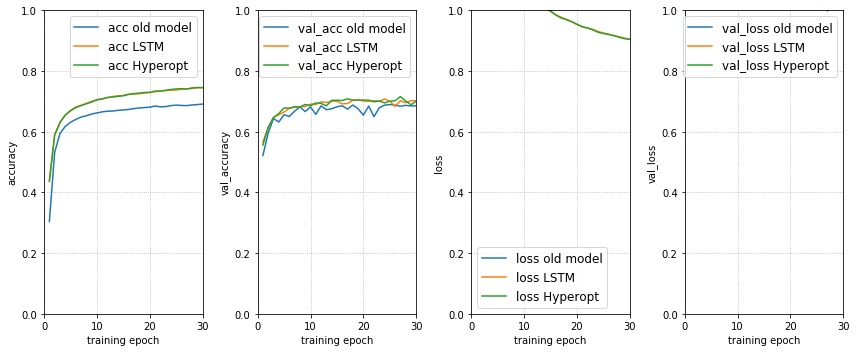

In [36]:
fig, axes = plt.subplots(1,4, figsize=(12,5), sharex=True)

nepoch = len(hist.history['loss'])
epochs = np.arange(1, nepoch+1)

ax = axes[0]
ax.plot(epochs, hist1.history['acc'], label='acc old model')
ax.plot(epochs, hist.history['acc'], label='acc LSTM')
ax.plot(epochs, hist2.history['acc'], label='acc Hyperopt')
ax.set(xlabel='training epoch',
       ylabel='accuracy',
       xlim=(0, nepoch),
       ylim=(0.,1.0)
      )
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')

ax = axes[1]
ax.plot(epochs, hist1.history['val_acc'], label='val_acc old model')
ax.plot(epochs, hist.history['val_acc'], label='val_acc LSTM')
ax.plot(epochs, hist2.history['val_acc'], label='val_acc Hyperopt')
ax.set(xlabel='training epoch',
       ylabel='val_accuracy',
       xlim=(0, nepoch),
       ylim=(0.,1.0)
      )
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')

ax = axes[2]
ax.plot(epochs, hist1.history['loss'], label='loss old model')
ax.plot(epochs, hist.history['loss'], label='loss LSTM')
ax.plot(epochs, hist2.history['loss'], label='loss Hyperopt')
ax.set(xlabel='training epoch',
       ylabel='loss',
       xlim=(0, nepoch),
       ylim=(0.,1.0)
      )
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')


ax = axes[3]
ax.plot(epochs, hist1.history['val_loss'], label='val_loss old model')
ax.plot(epochs, hist.history['val_loss'], label='val_loss LSTM')
ax.plot(epochs, hist2.history['val_loss'], label='val_loss Hyperopt')
ax.set(xlabel='training epoch',
       ylabel='val_loss',
       xlim=(0, nepoch),
       ylim=(0.,1.0)
      )
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')
fig.tight_layout();
fig.tight_layout();

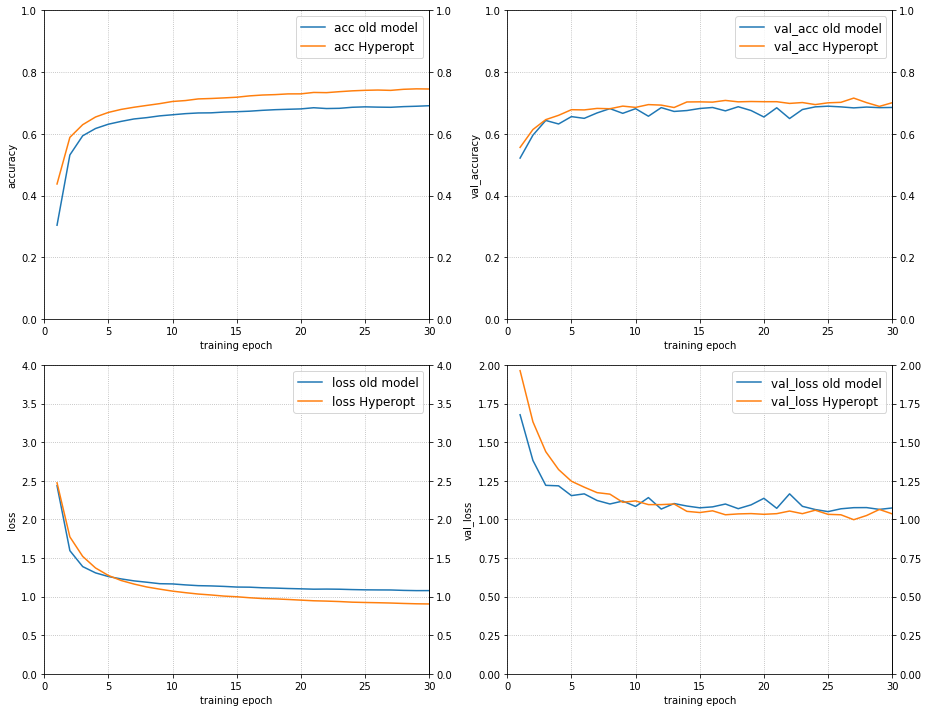

In [53]:
# fig, axes = plt.subplots(1,4, figsize=(12,5), sharex=True)
fig, ((axes[0], axes[1]),(axes[2], axes[3])) = plt.subplots(nrows=2, ncols=2, sharex=False, figsize=(13,10))

nepoch = len(hist.history['loss'])
epochs = np.arange(1, nepoch+1)

ax = axes[0]
ax.plot(epochs, hist1.history['acc'], label='acc old model')
ax.plot(epochs, hist2.history['acc'], label='acc Hyperopt')
ax.set(xlabel='training epoch',
       ylabel='accuracy',
       xlim=(0, nepoch),
       ylim=(0.,1.0)
      )
ax.legend(fontsize=12, loc='best')
ax.secondary_yaxis('right')
ax.grid(ls=':')

ax = axes[1]
ax.plot(epochs, hist1.history['val_acc'], label='val_acc old model')
ax.plot(epochs, hist2.history['val_acc'], label='val_acc Hyperopt')
ax.set(xlabel='training epoch',
       ylabel='val_accuracy',
       xlim=(0, nepoch),
       ylim=(0.,1.0)
      )
ax.legend(fontsize=12, loc='best')
ax.secondary_yaxis('right')
ax.grid(ls=':')

ax = axes[2]
ax.plot(epochs, hist1.history['loss'], label='loss old model')
ax.plot(epochs, hist2.history['loss'], label='loss Hyperopt')
ax.set(xlabel='training epoch',
       ylabel='loss',
       xlim=(0, nepoch),
       ylim=(0.,4.0)
      )
ax.secondary_yaxis('right')
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')


ax = axes[3]
ax.plot(epochs, hist1.history['val_loss'], label='val_loss old model')
ax.plot(epochs, hist2.history['val_loss'], label='val_loss Hyperopt')
ax.set(xlabel='training epoch',
       ylabel='val_loss',
       xlim=(0, nepoch),
       ylim=(0.,2.0)
      )
ax.legend(fontsize=12, loc='best')
ax.secondary_yaxis('right')
ax.grid(ls=':')
fig.tight_layout();
